
# Preprocessing & Modelling – RandomForestClassifier

- In this notebook, we take the insights from the EDA and transform the raw dataset into a machine-ready format.
- The goal is to build a clean preprocessing pipeline and train a predictive model (RandomForestClassfier) for the binary classification target at_risk, which identifies employees with low satisfaction (rating ≤ 3).

- We will:

1. Prepare the data for modelling

    - encode categorical variables,

    - handle missing values,

    - select relevant features,

    - build a reproducible scikit-learn pipeline.

2. Train and evaluate classification models

    - and a Random Forest, which is well-suited to our encoded categorical data.

This notebook follows a structured ML workflow to ensure reproducibility, clarity, and alignment with the business goal:

**predict which employees are at risk of low satisfaction.**




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
# Load the cleaned dataset
df_encoded = pd.read_csv("/content/pwc_with_at_risk.csv")


In [ ]:
df_encoded

 # 1. Preprocessing

## A. Ordinal encoding on position_level

In [ ]:
position_order = ['Intern', 'Entry Level', 'Associate', 'Senior Associate', 'Manager', 'Senior Manager', 'Director', 'Partner', 'Unknown']

# Fill NaN values with 'Unknown' BEFORE encoding
df_encoded['position_level'] = df_encoded['position_level'].fillna('Unknown')

# Apply ordinal encoding
df_encoded['position_level_encoded'] = pd.Categorical(df_encoded['position_level'], categories=position_order, ordered=True).codes

print("DataFrame after ordinal encoding 'position_level' column:")
display(df_encoded.head())

## B. One Hot encoding on function_area column:

In [ ]:
# Reload the cleaned dataset to ensure 'function_area' is present
df_encoded = pd.read_csv("/content/pwc_with_at_risk.csv")

# Re-apply ordinal encoding for 'position_level' as it was done before
position_order = ['Intern', 'Entry Level', 'Associate', 'Senior Associate', 'Manager', 'Senior Manager', 'Director', 'Partner', 'Unknown']
df_encoded['position_level'] = df_encoded['position_level'].fillna('Unknown')
df_encoded['position_level_encoded'] = pd.Categorical(df_encoded['position_level'], categories=position_order, ordered=True).codes

# Apply get_dummies to df_encoded for 'function_area' and convert new columns to int type.
df_encoded = pd.get_dummies(df_encoded, columns=['function_area'], prefix='function_area', drop_first=False, dtype=int)

# Display the head of the DataFrame to show the new one-hot encoded columns
print("DataFrame after one-hot encoding 'function_area' column:")
display(df_encoded.head())

## B/ Encoding the country column

The country variable has 65 unique values, so One-Hot Encoding would create 65 extra columns : too large and inefficient for this project.
Label Encoding keeps the dataset compact by assigning one integer per country.

This choice works because the model used later is a RandomForestClassifier, a tree-based model that does not assume any numeric order between encoded labels.
Trees simply split on thresholds, so the numeric values do not create bias.

**Label Encoding is the most practical and compatible option given the high cardinality and the model we use.**

In [ ]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply Label Encoding to the 'country' column
df_encoded['country_encoded'] = label_encoder.fit_transform(df_encoded['country'])

# Display the head of the DataFrame to show the new encoded column
print("DataFrame after label encoding 'country' column:")
display(df_encoded.head())

# Explicitly show columns to confirm 'country_encoded' is present
print("Columns in df_encoded after country encoding:", df_encoded.columns.tolist())

# You can also see the mapping of countries to their encoded values
print("\nMapping of countries to their encoded values:")
for i, country in enumerate(label_encoder.classes_):
    print(f"{country}: {i}")

# Imputation of missing values

Three columns in our dataset : recommender_bin  approbation_pdg_bin and perspective_commerciale are the columns with the most missing values. In order to make future predictions, we must find a way to impute these missing values.

recommender_bin column is a collection of -1(Negtive) and +1(Positive) remarks by people who recommend or do not recommend the company for work. Similarly, approbation_pdg_bin is if employees recommend the direction of the company and prespective_commerciale is if employees think the company is a good commercial perspective in business.

The challenge in imputing these values is that recommender_bin column has only -1 and +1 as recommendations so only Yes and No, while in the other two columns we also have 0 along with -1 and 1. This means that we need to impute these three columns with different parameters to keep the original format of having only -1 and 1 imputed for the recommender_bin column while -1, 0 and 1 for the rest of the two. It is also important to keep the distribution of -1, 0 and 1 in the columns the same after imputation.

In [ ]:
columns_with_missing = ['recommender_bin', 'approbation_pdg_bin', 'perspective_commerciale_bin']

for col in columns_with_missing:
    print(f"\nProportion of values in '{col}':")
    percentages = df_encoded[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    display(percentages.sort_index())

For imputating missing values, we also kept into account the correlation of these three columns with other columns in the dataset. In the correlation matrix explined in the EDA part, these three columns were mostly correlated with themselves (around 50% and more) and with the rating column.

The code builds separate **RandomForestClassifier** to impute missing values in three categorical columns. For recommender_bin, the model is trained on rating and the other two columns, then used to predict missing entries.

Before imputation, the script simulates missingness on known data to evaluate performance, reporting accuracy, macro F1 scores, and confusion matrices. This ensures the model is tested on realistic conditions and that its predictions are consistent with the categorical constraints of each column.

Random Forest classifiers handle categorical targets well, can capture nonlinear relationships, and are robust to imbalanced distributions.

By training separate models for each column and using the others as predictors, the imputation leverages both the external driver (rating) and the mutual correlations among the three variables.

The evaluation step provides quantitative evidence of how well the model recovers known values, making the imputation process transparent and reliable.


In [ ]:
# Columns
cols_all = ["recommender_bin", "approbation_pdg_bin", "perspective_commerciale_bin"]

# Step 1: Track missing values before imputation
for c in cols_all:
    df_encoded[f"{c}_was_missing"] = df_encoded[c].isna()

# Dictionary to store evaluation results
eval_results = {}

# Step 2: Impute recommender_bin with only -1 or 1
target = "recommender_bin"
train_mask = df_encoded[target].notna()

# Simulate missingness for evaluation
np.random.seed(42)
eval_mask = train_mask.copy()

# Sample only from True values to set to False for evaluation
true_indices = eval_mask[eval_mask].index
sampled_indices = np.random.choice(true_indices, size=int(len(true_indices) * 0.2), replace=False)
eval_mask.loc[sampled_indices] = False

# Define feature columns for recommender_bin imputation
feature_cols_recommender = ["rating", "approbation_pdg_bin", "perspective_commerciale_bin"]

# Prepare X_train, y_train, X_test, y_test
X_train = df_encoded.loc[eval_mask, feature_cols_recommender].fillna(0) # Fill NaNs in features
y_train = df_encoded.loc[eval_mask, target]

# For testing, ensure y_test only contains known values from the original non-NaN entries
test_indices_known = (~eval_mask) & train_mask
X_test = df_encoded.loc[test_indices_known, feature_cols_recommender].fillna(0) # Fill NaNs in features
y_test = df_encoded.loc[test_indices_known, target]

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred = np.where(y_pred == 0, np.random.choice([-1, 1], size=len(y_pred)), y_pred)

# Evaluation
eval_results[target] = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_macro": f1_score(y_test, y_pred, average="macro"),
    "confusion_matrix": confusion_matrix(y_test, y_pred, labels=[-1, 1])
}

# Impute real missing values
miss_mask = df_encoded[target].isna()
if miss_mask.any():
    X_miss = df_encoded.loc[miss_mask, feature_cols_recommender].fillna(0) # Fill NaNs in features for prediction
    preds = clf.predict(X_miss)
    preds = np.where(preds == 0, np.random.choice([-1, 1], size=len(preds)), preds)
    df_encoded.loc[miss_mask, target] = preds

df_encoded[target] = df_encoded[target].astype(int)


In [ ]:
# Step 3: Impute approbation_pdg_bin and perspective_commerciale_bin with -1, 0, or 1
for target in ["approbation_pdg_bin", "perspective_commerciale_bin"]:
    train_mask = df_encoded[target].notna()

    np.random.seed(42)
    eval_mask = train_mask.copy()
    # Sample only from True values to set to False for evaluation
    true_indices = eval_mask[eval_mask].index
    sampled_indices = np.random.choice(true_indices, size=int(len(true_indices) * 0.2), replace=False)
    eval_mask.loc[sampled_indices] = False

    # Define feature columns for current target imputation
    feature_cols_other = ["rating", "recommender_bin"] + [c for c in cols_all if c != target and c != "recommender_bin"]

    # Prepare X_train, y_train, X_test, y_test
    X_train = df_encoded.loc[eval_mask, feature_cols_other].fillna(0) # Fill NaNs in features
    y_train = df_encoded.loc[eval_mask, target]

    # For testing, ensure y_test only contains known values from the original non-NaN entries
    test_indices_known = (~eval_mask) & train_mask
    X_test = df_encoded.loc[test_indices_known, feature_cols_other].fillna(0) # Fill NaNs in features
    y_test = df_encoded.loc[test_indices_known, target]

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred = np.clip(y_pred, -1, 1)

    # Evaluation
    eval_results[target] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "confusion_matrix": confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
    }

    # Impute real missing values
    miss_mask = df_encoded[target].isna()
    if miss_mask.any():
        X_miss = df_encoded.loc[miss_mask, feature_cols_other].fillna(0) # Fill NaNs in features for prediction
        preds = clf.predict(X_miss)
        preds = np.clip(preds, -1, 1)
        df_encoded.loc[miss_mask, target] = preds

    df_encoded[target] = df_encoded[target].astype(int)

In [ ]:
# Step 4: Sanity check
for c in cols_all:
    unique_vals = df_encoded[c].unique()
    print(f"\n {c} unique values after imputation: {unique_vals}")

# Step 5: Print evaluation results
for col, res in eval_results.items():
    print(f" Evaluation for {col}:")
    print(f" Accuracy: {res['accuracy']:.3f}")
    print(f" F1 Score (macro): {res['f1_macro']:.3f}")
    print(" Confusion Matrix:\n", pd.DataFrame(res["confusion_matrix"],
          index=["-1", "0", "1"][:res["confusion_matrix"].shape[0]],
          columns=["Pred -1", "Pred 0", "Pred 1"][:res["confusion_matrix"].shape[1]]))

In [ ]:
imputed_columns = ['recommender_bin', 'approbation_pdg_bin', 'perspective_commerciale_bin']

for col in imputed_columns:
    print(f"\nProportion of values in '{col}':")
    # Calculate proportions and format as percentages
    percentages = df_encoded[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
    display(percentages.sort_index())

In [ ]:
df_encoded

The model shows promising performance, especially for recommender_bin, which achieved 89.1% accuracy and a macro F1 score of 0.818. The confusion matrix indicates that it handles both classes reasonably well, though there’s some misclassification of negatives as positives. This is expected given the class imbalance (more positive responses), and the high F1 score confirms that the model maintains good balance across classes.

For perspective_commerciale_bin, the accuracy of 78.4% and F1 score of 0.697 suggest solid performance, with the confusion matrix showing decent separation between all three classes.

The weakest model is for approbation_pdg_bin, with 68.7% accuracy and F1 score of 0.597, indicating that it struggles more with class separation—especially distinguishing between neutral and positive responses. This could be due to overlapping patterns in the data or insufficient signal from the predictors.

Overall, the model is strong enough for imputation, especially for recommender_bin, but for improving the approbation_pdg_bin model, we can add more features or use a more expressive classifier like **XGBoost** or **CatBoost**


# Prediction

Since our objective is to predict an **employee’s satisfaction rating** from their characteristics (country, role, year, status, internal survey indicators, etc.), we will use a ML model to predict this. Our target column will be **at-risk** column which is a categorical column with discrete classes and we already know our labels along with what we want to predict(the rating and utimately at-risk), which makes our problem a supervised ML classification problem.


### 1. Feature preprocessing

Columns like `country`, `position_level` and `date`, the `rating` column (as the target `at_risk` is derived from it), and the temporary `_was_missing` columns were dropped as they can later lead to data leakage in the model. The target column is `at_risk` column.

In [ ]:
columns_to_drop = [
    'country',
    'position_level',
    'date',
    'rating',
    'recommender_bin_was_missing',
    'approbation_pdg_bin_was_missing',
    'perspective_commerciale_bin_was_missing'
]

# Define target variable (y)
y = df_encoded['at_risk']

# Define features (X) by dropping specified columns and the target column
X = df_encoded.drop(columns=columns_to_drop)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nFirst 5 rows of X:")
display(X.head())
print("\nFirst 5 rows of y:")
display(y.head())

Now that the features (X) and target (y) have been defined, the next step is to split the dataset into training and testing sets to prepare for model training and evaluation.



In [ ]:
# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
display(X_train.head())
print("\nFirst 5 rows of y_train:")
display(y_train.head())

The next step is to train a RandomForestClassifier model using the prepared training data, as specified in the instructions.



In [ ]:
# Using class_weight='balanced' to handle potential class imbalance in the target variable
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully.")

The model has been trained. Now, I need to evaluate its performance on the test set using various metrics such as accuracy, precision, recall, F1-score, and a confusion matrix, as specified in the instructions.



In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Model Performance Evaluation:\n")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not at Risk (0)', 'At Risk (1)'],
            yticklabels=['Not at Risk (0)', 'At Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.show()


### Summary of RandomForestClassifier Performance

The RandomForestClassifier achieved an **Accuracy of 0.7518**, meaning it correctly classified about 75.18% of the 'at_risk' cases.

- **Precision (0.6042)** indicates that when the model predicts an employee is 'at risk', it is correct approximately 60.42% of the time. This is important for minimizing false positives, i.e., incorrectly flagging employees as at-risk when they are not.

- **Recall (0.6424)** suggests that the model identifies about 64.24% of all actual 'at risk' employees. This metric is crucial for minimizing false negatives, i.e., failing to identify employees who are truly at-risk.

- The **F1-Score (0.6227)** is the harmonic mean of precision and recall, providing a balanced measure of the model's performance. A moderate F1-score indicates a reasonable balance between identifying at-risk employees and not incorrectly flagging non-at-risk employees.

### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of the model's predictions:

- **True Negatives (TN): 4754** - Correctly identified as 'Not at Risk' (0).
- **False Positives (FP): 1166** - Incorrectly identified as 'At Risk' (1) when they were 'Not at Risk' (0).
- **False Negatives (FN): 991** - Incorrectly identified as 'Not at Risk' (0) when they were 'At Risk' (1).
- **True Positives (TP): 1780** - Correctly identified as 'At Risk' (1).

**Implications:**

The model demonstrates a good overall accuracy. However, there's a notable number of False Positives (1166) and False Negatives (991). The relatively lower precision compared to recall indicates that the **model is more prone to flagging non-at-risk employees as at-risk than missing actual at-risk employees.**

Depending on the business context, the cost of False Positives versus False Negatives needs to be carefully considered. For instance, **if the goal is to intervene with all potentially at-risk employees, a higher recall might be preferred**, even at the cost of some precision. If resources for intervention are limited, a higher precision might be more desirable. T

he `class_weight='balanced'` parameter in the RandomForestClassifier helped to address potential class imbalance, leading to a more balanced recall score for both classes.

Further improvements could explore hyperparameter tuning, feature engineering, or investigating more complex models to better distinguish between the classes.

## Hyperparameter Tuning with RandomizedSearchCV

In [ ]:
# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(low=100, high=500),
    'max_depth': randint(low=5, high=15),
    'min_samples_leaf': randint(low=1, high=20),
    'min_samples_split': randint(low=2, high=25),
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# Initialize a RandomForestClassifier with class_weight='balanced'
rf_random = RandomForestClassifier(random_state=42, class_weight='balanced')

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_random,
                                   param_distributions=param_distributions,
                                   n_iter=50, # Number of parameter settings that are sampled
                                   cv=3, # 3-fold cross-validation
                                   scoring='f1',
                                   n_jobs=-1, # Use all available cores
                                   random_state=42,
                                   verbose=2)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

print("Best parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print("Best F1-score found by RandomizedSearchCV:")
print(random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found by RandomizedSearchCV:
{'bootstrap': True, 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 24, 'n_estimators': 351}
Best F1-score found by RandomizedSearchCV:
0.6654818378616633


RandomForestClassifier model trained successfully with RandomizedSearchCV best parameters.

Model Performance Evaluation (RandomForest with RandomizedSearchCV params):

Accuracy: 0.7409
Precision: 0.5657
Recall: 0.8062
F1-Score: 0.6649


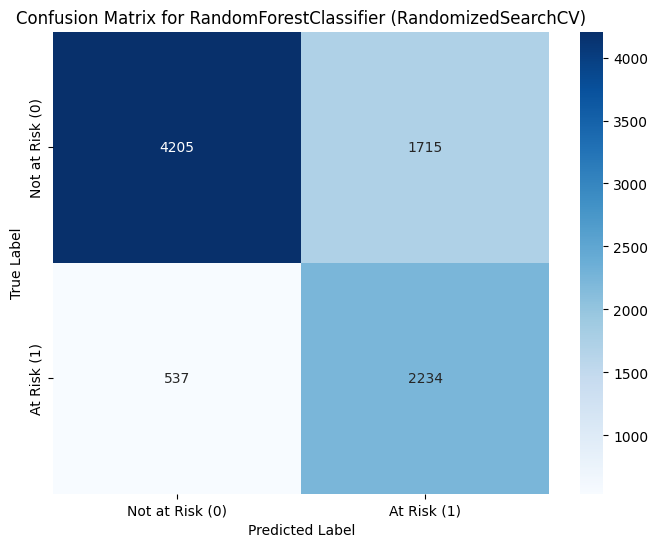

In [ ]:
# Get the best parameters from RandomizedSearchCV
best_params_random = random_search.best_params_

# Initialize a new RandomForestClassifier with the best parameters
# and retain class_weight='balanced' and random_state for reproducibility
model_random = RandomForestClassifier(random_state=42, class_weight='balanced', **best_params_random)

# Train the new model
model_random.fit(X_train, y_train)

print("RandomForestClassifier model trained successfully with RandomizedSearchCV best parameters.")

# Make predictions on the test set using the new model
y_pred_random = model_random.predict(X_test)

# Calculate evaluation metrics
accuracy_random = accuracy_score(y_test, y_pred_random)
precision_random = precision_score(y_test, y_pred_random)
recall_random = recall_score(y_test, y_pred_random)
f1_random = f1_score(y_test, y_pred_random)
conf_matrix_random = confusion_matrix(y_test, y_pred_random)

print(f"\nModel Performance Evaluation (RandomForest with RandomizedSearchCV params):\n")
print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1-Score: {f1_random:.4f}")

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not at Risk (0)', 'At Risk (1)'],
            yticklabels=['Not at Risk (0)', 'At Risk (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for RandomForestClassifier (RandomizedSearchCV)')
plt.show()

In [ ]:
predictions_random_df = pd.DataFrame({
    'True_at_risk': y_test,
    'Predicted_at_risk_RandomizedSearch': y_pred_random
}, index=y_test.index)

print("DataFrame with True vs. Predicted 'at_risk' values from RandomizedSearchCV:")
display(predictions_random_df.head())

DataFrame with True vs. Predicted 'at_risk' values from RandomizedSearchCV:


,True_at_risk,Predicted_at_risk_RandomizedSearch
30979,0,1
39523,0,0
36659,0,0
32170,0,0
33233,1,1


## Calculate and Visualize Feature Importances

To understand how the `RandomForestClassifier` (tuned with RandomizedSearchCV) makes its predictions, we will extract and visualize the feature importances. This will show us which input features the model considered most relevant for determining 'at-risk' status.

Top 10 Feature Importances for RandomizedSearchCV Model:


,Feature,Importance
1,recommender_bin,0.424256
2,perspective_commerciale_bin,0.261016
3,approbation_pdg_bin,0.222812
5,position_level_encoded,0.027306
4,year,0.026335
14,country_encoded,0.023341
0,employee_status,0.006102
9,function_area_Other,0.001975
6,function_area_Audit–Assurance,0.001639
7,function_area_Consulting–Advisory,0.001556


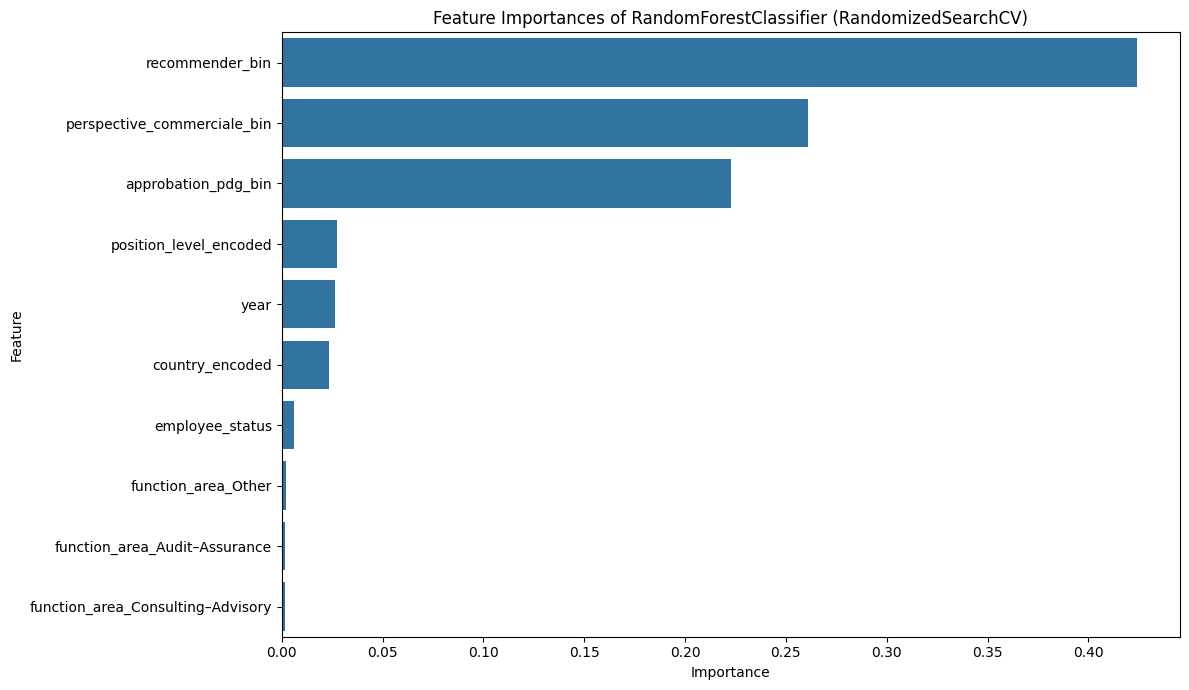

In [ ]:
feature_importances_random = model_random.feature_importances_
feature_names = X.columns

importance_df_random = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_random
}).sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importances for RandomizedSearchCV Model:")
display(importance_df_random.head(10))

plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df_random.head(10))
plt.title('Feature Importances of RandomForestClassifier (RandomizedSearchCV)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

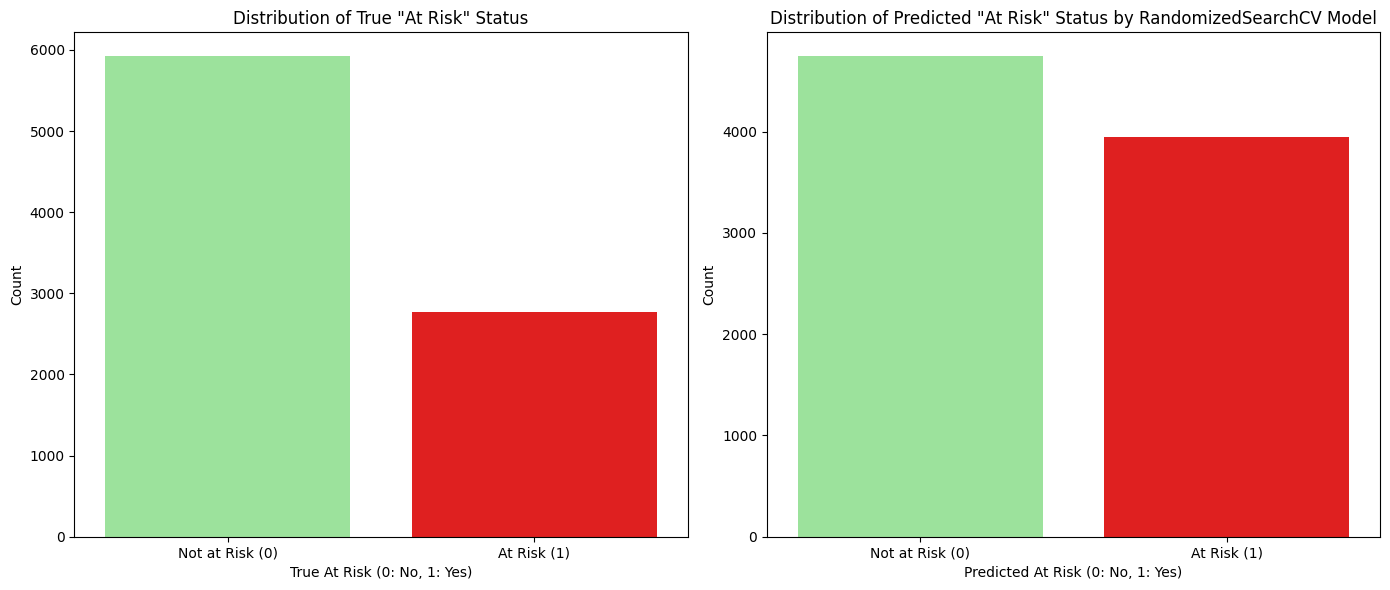

In [ ]:
plt.figure(figsize=(14, 6))

# Subplot 1: Distribution of True 'at_risk' status
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
sns.countplot(x='True_at_risk', data=predictions_random_df,
              palette={0: 'lightgreen', 1: 'red'}, hue='True_at_risk', legend=False)
plt.title('Distribution of True "At Risk" Status')
plt.xlabel('True At Risk (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not at Risk (0)', 'At Risk (1)'])

# Subplot 2: Distribution of Predicted 'at_risk' status from RandomizedSearchCV Model
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
sns.countplot(x='Predicted_at_risk_RandomizedSearch',
              data=predictions_random_df, palette={0: 'lightgreen', 1: 'red'},
              hue='Predicted_at_risk_RandomizedSearch', legend=False)
plt.title('Distribution of Predicted "At Risk" Status by RandomizedSearchCV Model')
plt.xlabel('Predicted At Risk (0: No, 1: Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not at Risk (0)', 'At Risk (1)'])

plt.tight_layout()
plt.show()

## Granular Analysis of Predicted At-Risk Status with Original Labels

This section visualizes the proportion of predicted 'at-risk' employees across various demographic and organizational features, using their original, human-readable labels.

In [ ]:
# Ensure predictions_random_df is available from previous steps
predictions_random_df = pd.DataFrame({
    'True_at_risk': y_test,
    'Predicted_at_risk_RandomizedSearch': y_pred_random
}, index=y_test.index)

# Merge predictions with original features from X_test
predictions_with_features = predictions_random_df.merge(
    X_test.reset_index(),
    left_index=True,
    right_on='index'
).set_index('index')

predictions_with_features.rename(columns={'Predicted_at_risk_RandomizedSearch': 'Predicted_at_risk'}, inplace=True)

# Mapping encoded values back to original labels for better interpretability

# Making sure all country_encoded values in predictions_with_features exist in label_encoder.classes_
# If not, handling missing values before inverse_transform
valid_country_codes = predictions_with_features['country_encoded'].unique()
# Create a mapping for only the present encoded values
country_map = {code: label_encoder.inverse_transform([code])[0] for code in valid_country_codes}
predictions_with_features['country_label'] = predictions_with_features['country_encoded'].map(country_map)


# Employee status labels
status_mapping = {0: 'Inactive', 1: 'Active'}
predictions_with_features['employee_status_label'] = predictions_with_features['employee_status'].map(status_mapping)

# Function Area labels (These are one-hot encoded in X_test, need to convert back)
# Identifying function_area columns in X_test
function_area_cols = [col for col in X_test.columns if col.startswith('function_area_')]

# Calculating count of predicted 'at_risk' and total employees for each feature

# 1. Country
country_at_risk_summary = predictions_with_features.groupby('country_label')['Predicted_at_risk'].agg(
    Num_at_risk='sum',
    Total_employees='size'
).reset_index()
country_at_risk_summary['Proportion_at_risk'] = country_at_risk_summary['Num_at_risk'] / country_at_risk_summary['Total_employees']

# 2. Employee Status
employee_status_at_risk_summary = predictions_with_features.groupby('employee_status_label')['Predicted_at_risk'].agg(
    Num_at_risk='sum',
    Total_employees='size'
).reset_index()
employee_status_at_risk_summary['Proportion_at_risk']
= employee_status_at_risk_summary['Num_at_risk'] / employee_status_at_risk_summary['Total_employees']

# 3. Function Area
function_area_at_risk_summary_list = []
for col in function_area_cols:
    # Get the original function area name
    fa_name = col.replace('function_area_', '')

    # Filter data for this function area (where the one-hot encoded column is 1)
    filtered_df = predictions_with_features[predictions_with_features[col] == 1]

    if not filtered_df.empty:
        num_at_risk = filtered_df['Predicted_at_risk'].sum()
        total_employees = len(filtered_df)
        proportion = num_at_risk / total_employees if total_employees > 0 else 0
        function_area_at_risk_summary_list.append({
            'Function_Area': fa_name,
            'Num_at_risk': num_at_risk,
            'Total_employees': total_employees,
            'Proportion_at_risk': proportion
        })

function_area_at_risk_summary_df = pd.DataFrame(function_area_at_risk_summary_list)

print("Predicted At-Risk by Country (Top 10):")
display(country_at_risk_summary.sort_values
 (by='Proportion_at_risk', ascending=False).head(10))

print("Predicted At-Risk by Employee Status:")
display(employee_status_at_risk_summary)

print("Predicted At-Risk by Function Area:")
display(function_area_at_risk_summary_df.sort_values
 (by='Proportion_at_risk', ascending=False))


# visualizing these proportions
plt.figure(figsize=(24, 8)) # Increased figure size for better readability

# Plot for Country
plt.subplot(1, 3, 1)
sns.barplot(x='country_label', y='Proportion_at_risk',
            data=country_at_risk_summary.sort_values
             (by='Proportion_at_risk', ascending=False).head(10),
            palette='viridis', hue='country_label', legend=False)
plt.title('Top 10 Countries by Predicted At-Risk Proportion (Count/Total)')
plt.xlabel('Country')
plt.ylabel('Proportion of Predicted At-Risk')
plt.xticks(rotation=45, ha='right')

# Plot for Employee Status
plt.subplot(1, 3, 2)
sns.barplot(x='employee_status_label', y='Proportion_at_risk',
            data=employee_status_at_risk_summary, palette='magma',
            hue='employee_status_label', legend=False)
plt.title('Predicted At-Risk Proportion by Employee Status (Count/Total)')
plt.xlabel('Employee Status')
plt.ylabel('Proportion of Predicted At-Risk')

# Plot for Function Area
plt.subplot(1, 3, 3)
sns.barplot(x='Function_Area', y='Proportion_at_risk',
            data=function_area_at_risk_summary_df.sort_values(
            by='Proportion_at_risk', ascending=False), palette='cividis',
            hue='Function_Area', legend=False)
plt.title('Predicted At-Risk Proportion by Function Area (Count/Total)')
plt.xlabel('Function Area')
plt.ylabel('Proportion of Predicted At-Risk')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (ipython-input-24388589.py, line 49)

### Interpreting 'Proportion_at_risk'

The `Proportion_at_risk` for a given category (e.g., a specific country, employee status, or function area) represents the **percentage of employees within that category who are predicted by the model to be 'at risk' (having a satisfaction rating ≤ 3).**

*   **A proportion of 1.0 (or 100%)** means that _all_ employees in that particular category are predicted to be at risk.
*   **A proportion of 0.654 (or 65.4%)** means that 65.4% of the employees in that category are predicted to be at risk. This indicates a higher concentration of at-risk employees within that group compared to a group with a lower proportion, but it doesn't mean *every* individual in that group is at risk.
*   **A proportion of 0.0 (or 0%)** means that _none_ of the employees in that category are predicted to be at risk.